In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import argparse
import time
import msgpack
from enum import Enum, auto

import numpy as np

from voxmap import create_voxmap
from planning_utils import a_star, heuristic, create_grid
from udacidrone import Drone
from udacidrone.connection import MavlinkConnection
from udacidrone.messaging import MsgID
from udacidrone.frame_utils import global_to_local

In [5]:
import matplotlib.pyplot as plt

%matplotlib inline

In [6]:
class States(Enum):
    MANUAL = auto()
    ARMING = auto()
    TAKEOFF = auto()
    WAYPOINT = auto()
    LANDING = auto()
    DISARMING = auto()
    PLANNING = auto()

In [7]:
class MotionPlanning(Drone):

    def __init__(self, connection):
        super().__init__(connection)

        self.target_position = np.array([0.0, 0.0, 0.0])
        self.waypoints = []
        self.in_mission = True
        self.check_state = {}

        # initial state
        self.flight_state = States.MANUAL

        # register all your callbacks here
        self.register_callback(MsgID.LOCAL_POSITION, self.local_position_callback)
        self.register_callback(MsgID.LOCAL_VELOCITY, self.velocity_callback)
        self.register_callback(MsgID.STATE, self.state_callback)

    def local_position_callback(self):
        if self.flight_state == States.TAKEOFF:
            if -1.0 * self.local_position[2] > 0.95 * self.target_position[2]:
                self.waypoint_transition()
        elif self.flight_state == States.WAYPOINT:
            if np.linalg.norm(self.target_position[0:2] - self.local_position[0:2]) < 1.0:
                if len(self.waypoints) > 0:
                    self.waypoint_transition()
                else:
                    if np.linalg.norm(self.local_velocity[0:2]) < 1.0:
                        self.landing_transition()

    def velocity_callback(self):
        if self.flight_state == States.LANDING:
            if self.global_position[2] - self.global_home[2] < 0.1:
                if abs(self.local_position[2]) < 0.01:
                    self.disarming_transition()

    def state_callback(self):
        if self.in_mission:
            if self.flight_state == States.MANUAL:
                self.arming_transition()
            elif self.flight_state == States.ARMING:
                if self.armed:
                    self.plan_path()
            elif self.flight_state == States.PLANNING:
                self.takeoff_transition()
            elif self.flight_state == States.DISARMING:
                if ~self.armed & ~self.guided:
                    self.manual_transition()

    def arming_transition(self):
        self.flight_state = States.ARMING
        print("arming transition")
        self.arm()
        self.take_control()

    def takeoff_transition(self):
        self.flight_state = States.TAKEOFF
        print("takeoff transition")
        self.takeoff(self.target_position[2])

    def waypoint_transition(self):
        self.flight_state = States.WAYPOINT
        print("waypoint transition")
        self.target_position = self.waypoints.pop(0)
        print('target position', self.target_position)
        self.cmd_position(self.target_position[0], self.target_position[1], self.target_position[2], self.target_position[3])

    def landing_transition(self):
        self.flight_state = States.LANDING
        print("landing transition")
        self.land()

    def disarming_transition(self):
        self.flight_state = States.DISARMING
        print("disarm transition")
        self.disarm()
        self.release_control()

    def manual_transition(self):
        self.flight_state = States.MANUAL
        print("manual transition")
        self.stop()
        self.in_mission = False

    def send_waypoints(self):
        print("Sending waypoints to simulator ...")
        data = msgpack.dumps(self.waypoints)
        self.connection._master.write(data)

    def plan_path(self):
        self.flight_state = States.PLANNING
        print("Searching for a path ...")
        TARGET_ALTITUDE = 5
        SAFETY_DISTANCE = 5

        self.target_position[2] = TARGET_ALTITUDE

        # TODO: read lat0, lon0 from colliders into floating point values
        
        # TODO: set home position to (lon0, lat0, 0)

        # TODO: retrieve current global position
 
        # TODO: convert to current local position using global_to_local()
        
        print('global home {0}, position {1}, local position {2}'.format(self.global_home, self.global_position,
                                                                         self.local_position))
        # Read in obstacle map
        data = np.loadtxt('colliders.csv', delimiter=',', dtype='Float64', skiprows=2)
        
        # Define a grid for a particular altitude and safety margin around obstacles
        grid, north_offset, east_offset = create_grid(data, TARGET_ALTITUDE, SAFETY_DISTANCE)
        print("North offset = {0}, east offset = {1}".format(north_offset, east_offset))
        # Define starting point on the grid (this is just grid center)
        grid_start = (-north_offset, -east_offset)
        # TODO: convert start position to current position rather than map center
        
        # Set goal as some arbitrary position on the grid
        grid_goal = (-north_offset + 10, -east_offset + 10)
        # TODO: adapt to set goal as latitude / longitude position and convert

        # Run A* to find a path from start to goal
        # TODO: add diagonal motions with a cost of sqrt(2) to your A* implementation
        # or move to a different search space such as a graph (not done here)
        print('Local Start and Goal: ', grid_start, grid_goal)
        path, _ = a_star(grid, heuristic, grid_start, grid_goal)
        # TODO: prune path to minimize number of waypoints
        # TODO (if you're feeling ambitious): Try a different approach altogether!

        # Convert path to waypoints
        waypoints = [[p[0] + north_offset, p[1] + east_offset, TARGET_ALTITUDE, 0] for p in path]
        # Set self.waypoints
        self.waypoints = waypoints
        # TODO: send waypoints to sim (this is just for visualization of waypoints)
        self.send_waypoints()

    def start(self):
        self.start_log("Logs", "NavLog.txt")

        print("starting connection")
        self.connection.start()

        # Only required if they do threaded
        # while self.in_mission:
        #    pass

        self.stop_log()

In [8]:
def main():
    print("main")
    #parser = argparse.ArgumentParser()
    #parser.add_argument('--port', type=int, default=5760, help='Port number')
    #parser.add_argument('--host', type=str, default='127.0.0.1', help="host address, i.e. '127.0.0.1'")
    #args = parser.parse_args()

    conn = MavlinkConnection('tcp:{0}:{1}'.format('127.0.0.1', 5760), timeout=60)
    drone = MotionPlanning(conn)
    time.sleep(1)

    drone.start()

In [9]:
from planning_utils import a_star

In [10]:
def plot(grid, start_ne, goal_ne, goal_list=None, path=None):
    plt.figure(figsize=(24, 12))
    plt.imshow(grid, cmap='Greys', origin='lower')
    
    # For the purposes of the visual the east coordinate lay along
    # the x-axis and the north coordinates long the y-axis.
    plt.plot(start_ne[1], start_ne[0], 'gx', markersize=5, markeredgewidth=5)
    plt.plot(goal_ne[1], goal_ne[0], 'rx', markersize=5, markeredgewidth=5)
    
    for g in goal_list:
        plt.plot(g[1], g[0], 'bo', markeredgewidth=2)

    if path is not None:
        pp = np.array(path)
        #pp = np.array(parr)
        plt.plot(pp[:, 1], pp[:, 0], 'g')

    plt.xlabel('EAST')
    plt.ylabel('NORTH')
    plt.show()    

In [11]:
def point(p):
    return np.array([p[0], p[1], 1.]).reshape(1, -1)

def collinearity_check(p1, p2, p3, epsilon=1e-6):   
    m = np.concatenate((p1, p2, p3), 0)
    det = np.linalg.det(m)
    return abs(det) < epsilon

def prune_path(path):
    pruned_path = [p for p in path]
    # TODO: prune the path!
    i = 0
    while i < len(pruned_path) - 2:
        p1 = point(pruned_path[i])
        p2 = point(pruned_path[i+1])
        p3 = point(pruned_path[i+2])
        if collinearity_check(p1,p2,p3):
            pruned_path.remove(pruned_path[i+1])
        else:
            i += 1
    return pruned_path

main
Logs/TLog.txt
Logs/NavLog.txt
starting connection
arming transition
Searching for a path ...
global home [-122.39745   37.79248    0.     ], position [-1.22397452e+02  3.77924812e+01  4.70000000e-02], local position [ 0.13275021 -0.18100844 -0.04747775]
North offset = -316, east offset = -445
(37.79248, -122.39745)  vs  (316, 445)
lla:  37.7924812 -122.397452 0.047
gh:  [-122.39745   37.79248    0.     ]
gp:  [-1.22397452e+02  3.77924812e+01  4.70000000e-02]
lp: [ 0.13200478 -0.17694882 -0.047     ]
gsf:  316.13200477696955 444.8230511834845
gs:  (316, 445)
change [ 0.11460689 -0.35240085  0.19033133]
goal:  (-122.39630593113098, 37.78895719152041, 1.9503132743517488)
lg:  [-390.20464936  103.25363624   -1.95031327]
ggf:  -74.20464936457574 548.2536362371175
548 920
gg:  (0, 548) 0.0
gg:  (0, 548)
Local Start and Goal:  (316, 445) (0, 548)


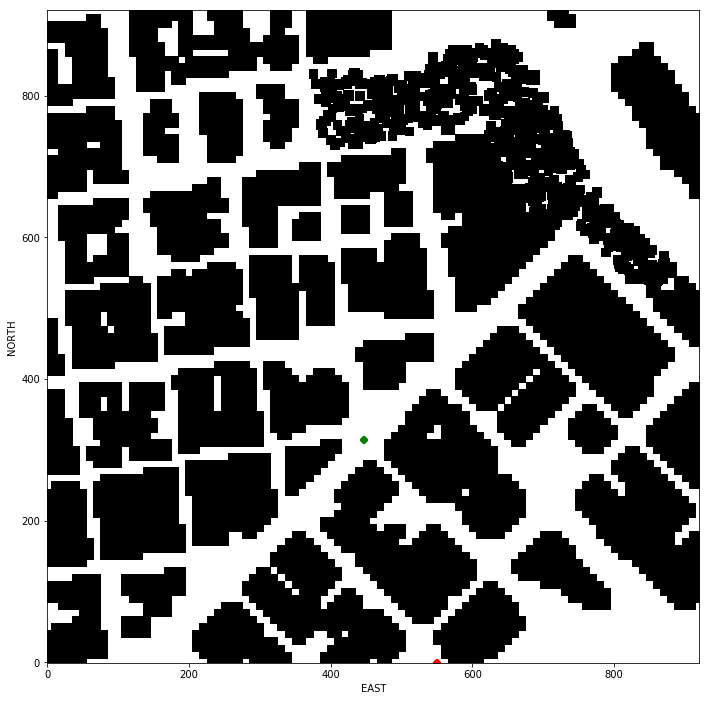

1000 6866 28.45584412271572 337.5318865459356 (298, 466)
2000 12836 50.42640687119284 342.2225686005754 (284, 481)
3000 19355 35.62741699796952 344.61932627716084 (300, 474)
4000 25489 149.50966799187796 346.41065833981907 (193, 509)
6000 37259 30.69848480983501 349.7784121007882 (294, 424)
7000 42763 153.2081528017129 352.0246511110836 (198, 530)
8000 48445 62.94112549695422 354.9993388723017 (263, 421)
9000 54555 34.87005768508881 359.07523963010334 (297, 418)
10000 60476 147.30865786510137 363.2762480262179 (201, 469)
11000 66453 172.70562748477158 367.5388895320924 (194, 566)
12000 72151 26.870057685088817 372.24087289679716 (335, 464)
13000 78017 119.88225099390843 376.29792914171594 (218, 413)
14000 83550 93.29646455628153 379.91991091055314 (243, 396)
17000 101164 104.85281374238556 391.6715718458262 (236, 385)
18000 106955 253.10259710444205 395.86463687692503 (130, 607)
19000 113081 271.51681066681516 398.5758520609639 (112, 608)
20000 118682 48.24264068711928 400.749378211382

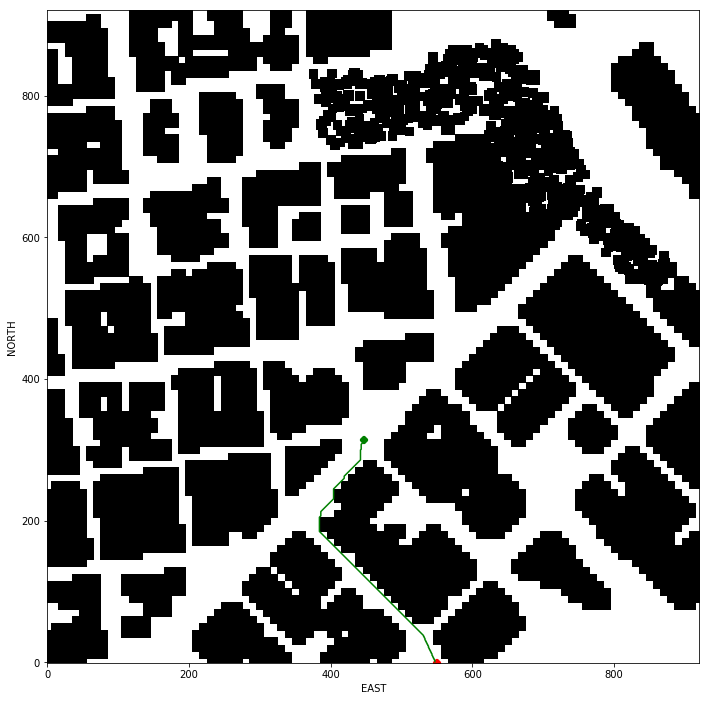

48


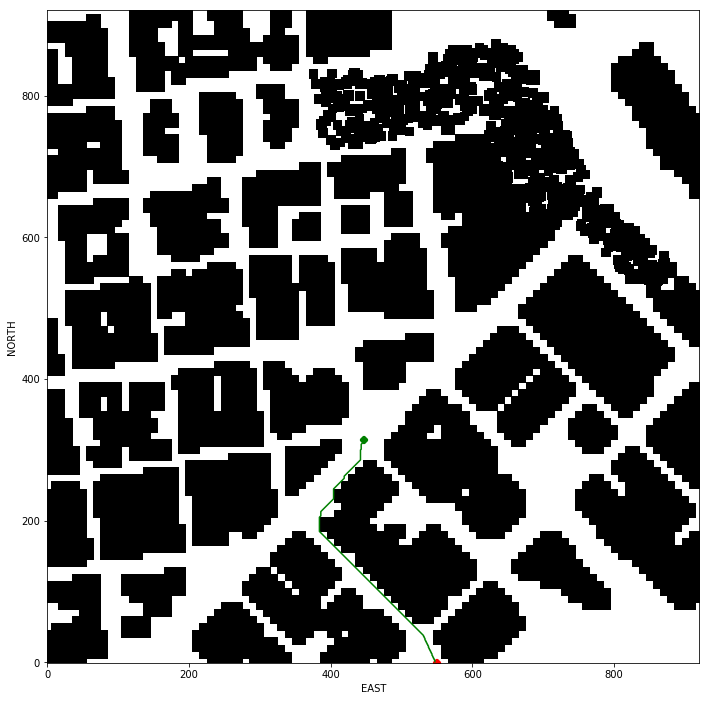

A* path:
(316, 445)
(315, 445)
(314, 445)
(313, 445)
(312, 445)
(311, 445)
(310, 445)
(309, 444)
(308, 443)
(307, 443)
(306, 443)
(305, 443)
(304, 443)
(303, 443)
(302, 443)
(301, 443)
(300, 442)
(299, 442)
(298, 442)
(297, 442)
(296, 442)
(295, 442)
(294, 442)
(293, 442)
(292, 442)
(291, 442)
(290, 442)
(289, 442)
(288, 442)
(287, 442)
(286, 442)
(285, 441)
(284, 440)
(283, 439)
(282, 438)
(281, 437)
(280, 436)
(279, 435)
(278, 434)
(277, 433)
(276, 432)
(275, 431)
(274, 430)
(273, 429)
(272, 428)
(271, 427)
(270, 426)
(269, 425)
(268, 424)
(267, 423)
(266, 422)
(265, 421)
(264, 420)
(263, 419)
(262, 419)
(261, 419)
(260, 419)
(259, 418)
(258, 417)
(257, 416)
(256, 415)
(255, 414)
(254, 413)
(253, 412)
(252, 411)
(251, 410)
(250, 409)
(249, 408)
(248, 407)
(247, 406)
(246, 405)
(245, 404)
(244, 404)
(243, 404)
(242, 404)
(241, 404)
(240, 404)
(239, 404)
(238, 404)
(237, 404)
(236, 404)
(235, 404)
(234, 404)
(233, 404)
(232, 404)
(231, 404)
(230, 403)
(229, 402)
(228, 401)
(227, 400)
(

In [12]:
def plan_path(self):
    self.flight_state = States.PLANNING
    print("Searching for a path ...")
    TARGET_ALTITUDE = 5
    SAFETY_DISTANCE = 5

    self.target_position[2] = TARGET_ALTITUDE

    # TODO: read lat0, lon0 from colliders into floating point values

    # TODO: set home position to (lon0, lat0, 0)

    # TODO: retrieve current global position

    # TODO: convert to current local position using global_to_local()

    print('global home {0}, position {1}, local position {2}'.format(self.global_home, self.global_position,
                                                                     self.local_position))
    # Read in obstacle map
    data = np.loadtxt('colliders.csv', delimiter=',', dtype='Float64', skiprows=2)
    voxmap = create_voxmap(data, 1)
    # Define a grid for a particular altitude and safety margin around obstacles
    grid, north_offset, east_offset = create_grid(data, TARGET_ALTITUDE, SAFETY_DISTANCE)
    print("North offset = {0}, east offset = {1}".format(north_offset, east_offset))

    # Define starting point on the grid (this is just grid center)
    with open('colliders.csv') as f:
        first_line = f.readline().strip()
    latlon = first_line.split(',')
    lon0 = float(latlon[0].strip().split(' ')[1])
    lat0 = float(latlon[1].strip().split(' ')[1])      
    #grid_start = (-north_offset, -east_offset)
    # TODO: convert start position to current position rather than map center
    self.set_home_position(lat0, lon0, 0)
    print((lon0, lat0), " vs ", (-north_offset, -east_offset))    
    print("lla: ",self._latitude, self._longitude, self._altitude)
    print("gh: ",self.global_home)
    print("gp: ",self.global_position)
    local_pos = global_to_local(self.global_position, global_home=self.global_home)
    print("lp:", local_pos)
    north, east, att = local_pos
    print("gsf: ", (north - north_offset), (east - east_offset))
    #3d
    #grid_start = (int(np.rint(north - north_offset)), int(np.rint(east - east_offset)), int(np.rint(self.global_position[2])))
    #2d
    grid_start = (int(np.rint(north - north_offset)), int(np.rint(east - east_offset)))
    print("gs: ",grid_start)
    

    
    # Set goal as some arbitrary position on the grid
    #grid_goal = (-north_offset + 10, -east_offset + 10)
    # TODO: adapt to set goal as latitude / longitude position and convert
    # grid_goal = (grid_start[0] + 10, grid_start[1] + 10)
    #goal = (-122.400600, 37.793401, 0)
    #goal = (lat0 + 0.0001, lon0 + 0.00001, 0)
    dist_idx = 100.0
    goal_obs = True
    goal_try = 0
    goal_list = []
    grid_shape = grid.shape
    while goal_obs and goal_try < 100:
        goal_try += 1
        change = np.random.rand(3)
        change -= 0.5
        print("change", change)
        goal = (self.global_position[0] + change[0] / dist_idx,
                self.global_position[1] + change[1] / (dist_idx),
                self.global_position[2] + change[2] * 10.0)
        print("goal: ", goal)
        local_goal = global_to_local(goal, global_home=self.global_home)
        print("lg: ", local_goal)
        ng, eg, ag = local_goal
        print("ggf: ", (ng - north_offset), (eg - east_offset))
        #3d
        #grid_goal = (int(np.rint(ng - north_offset)), int(np.rint(eg - east_offset)), int(np.rint(goal[2])))
        #2d
        grid_goal = (int(np.rint(ng - north_offset)), int(np.rint(eg - east_offset)))
        print(grid_goal[1], grid_shape[1] - 1)
        if grid_goal[0] >= grid_shape[0]:
            grid_goal = (grid_shape[0] - 1, grid_goal[1])
        elif grid_goal[0] < 0:
            grid_goal = (0, grid_goal[1])            
        if grid_goal[1] >= grid_shape[1]:
            grid_goal = (grid_goal[0], grid_shape[1] - 1)
        elif grid_goal[1] < 0:
            grid_goal = (grid_goal[0], 0)            
                    
        goal_obs = grid[grid_goal[0], grid_goal[1]]
        print("gg: ",grid_goal, goal_obs)
        if goal_obs:
            goal_list.append(grid_goal)
    
    #grid_goal = (grid_start[0] + 10, grid_start[1] + 10,0)    
    print("gg: ",grid_goal)
    # Run A* to find a path from start to goal
    # TODO: add diagonal motions with a cost of sqrt(2) to your A* implementation
    # or move to a different search space such as a graph (not done here)
    print('Local Start and Goal: ', grid_start, grid_goal)
    plot(grid, grid_start, grid_goal, goal_list=goal_list)
    #3d
    #path, _ = a_star(voxmap, heuristic, grid_start, grid_goal)
    #2d
    path, cost = a_star(grid, heuristic, grid_start, grid_goal)
    print(len(path), cost)
    plot(grid, grid_start, grid_goal, goal_list=[], path=path)
    
    pruned_path = prune_path(path)
    print(len(pruned_path))
    plot(grid, grid_start, grid_goal, goal_list=[], path=pruned_path)
        
    print("A* path:")
    for p in path:
        print(p)
        
    print("Pruned_path:")
    for p in pruned_path:
        print(p)
    #    print(p, p.cost, p.delta, (p.delta[0] + north_offset, p.delta[1] + east_offset, TARGET_ALTITUDE, 0))
    # TODO: prune path to minimize number of waypoints
    # TODO (if you're feeling ambitious): Try a different approach altogether!

    # Convert path to waypoints
    #waypoints = [[p[0] + north_offset, p[1] + east_offset, TARGET_ALTITUDE, 0] for p in path]
    waypoints = [[p[0] + north_offset, p[1] + east_offset, TARGET_ALTITUDE, 0] for p in pruned_path]
    
    # Set self.waypoints
    self.waypoints = waypoints
    # TODO: send waypoints to sim (this is just for visualization of waypoints)
    self.send_waypoints()
MotionPlanning.plan_path = plan_path
main()

main
Logs/TLog.txt
Logs/NavLog.txt
starting connection
arming transition
Searching for a path ...
global home [-122.3974533   37.7924804    0.       ], position [-122.3963065   37.7896431  -59.977    ], local position [-315.25228882  101.93479156   60.02344894]
North offset = -316, east offset = -445
(37.79248, -122.39745)  vs  (316, 445)
lla:  37.7896431 -122.3963065 -59.977
gh:  [-122.3974533   37.7924804    0.       ]
gp:  [-122.3963065   37.7896431  -59.977    ]
lp: [-314.14617698  103.00303194   59.977     ]
gsf:  1.8538230150006711 548.0030319403159
gs:  (2, 548)
change [-0.08164823 -0.48972896  0.3164519 ]
goal:  (-122.39712298226124, 37.78474581040119, -56.812481047790826)
lg:  [-857.96236444   34.61605424   56.81248105]
ggf:  -541.9623644440435 479.6160542448051
480 920
gg:  (0, 480) 1.0
change [-0.47205619 -0.38471689  0.23819978]
goal:  (-122.40102706192951, 37.78579593113181, -57.5950021816023)
lg:  [-743.66111808 -309.90224662   57.59500218]
ggf:  -427.66111807804555 135.0

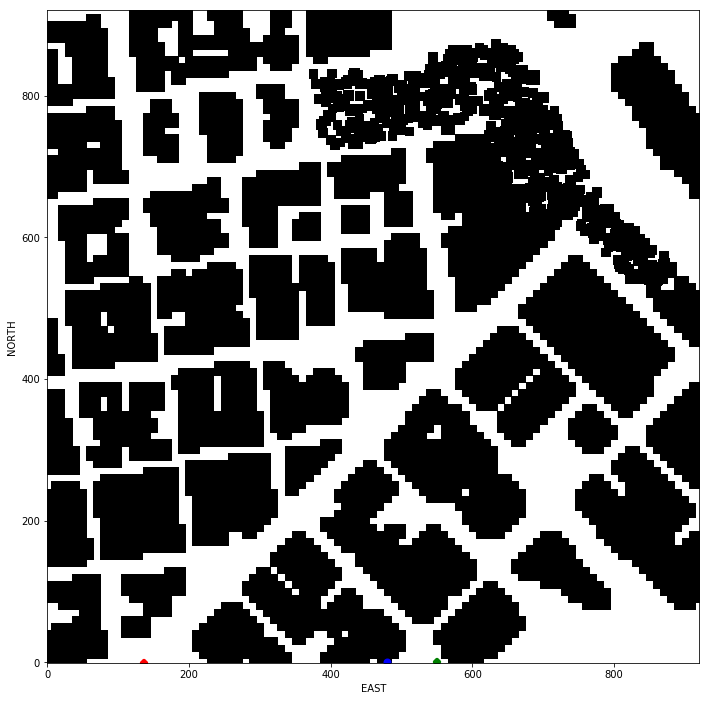

3000 16849 34.31370849898476 440.6559288010351 (33, 540)
5000 25128 90.36753236814702 456.12838319830354 (70, 494)
6000 29497 88.63961030678918 463.61694295504407 (72, 503)
7000 34267 148.66399692442877 474.3939464224754 (106, 443)
8000 40422 210.19090885901022 479.95562115474394 (82, 392)
9000 45388 182.70562748477158 489.4465605211044 (123, 416)
10000 50086 194.3330444827413 504.7021795461364 (140, 412)
13000 64232 257.14422766478486 555.4410596962364 (185, 369)
14000 71092 392.1097397793796 561.4023858098554 (106, 267)
15000 76915 315.0853531617394 562.1582169084488 (166, 318)
16000 81297 413.49451609023 562.6957225196687 (90, 254)
17000 85386 511.31789258109364 563.2120155624101 (22, 182)
19000 93378 510.48946545634743 564.2016614643305 (22, 184)
21000 101629 544.3595231414364 565.2401361592575 (6, 155)
Found a path.
414 566.844804515675


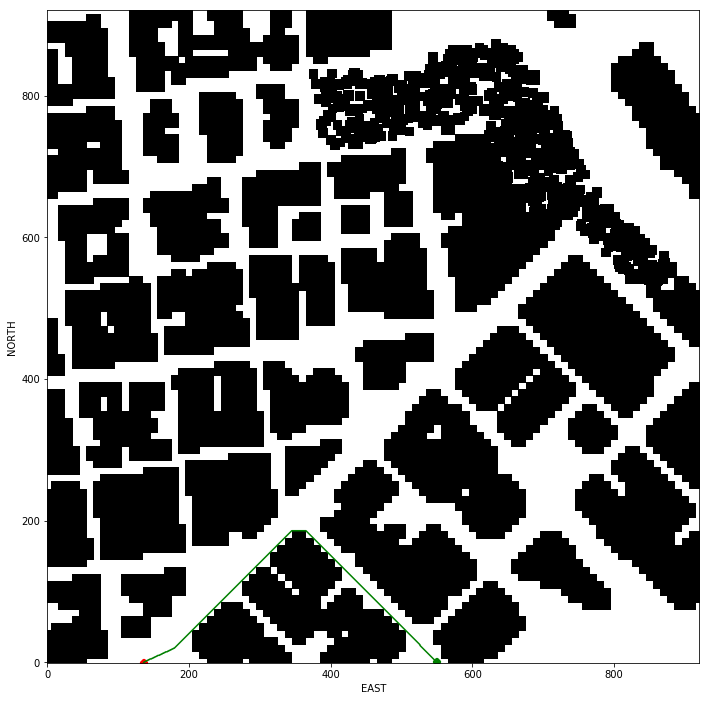

46


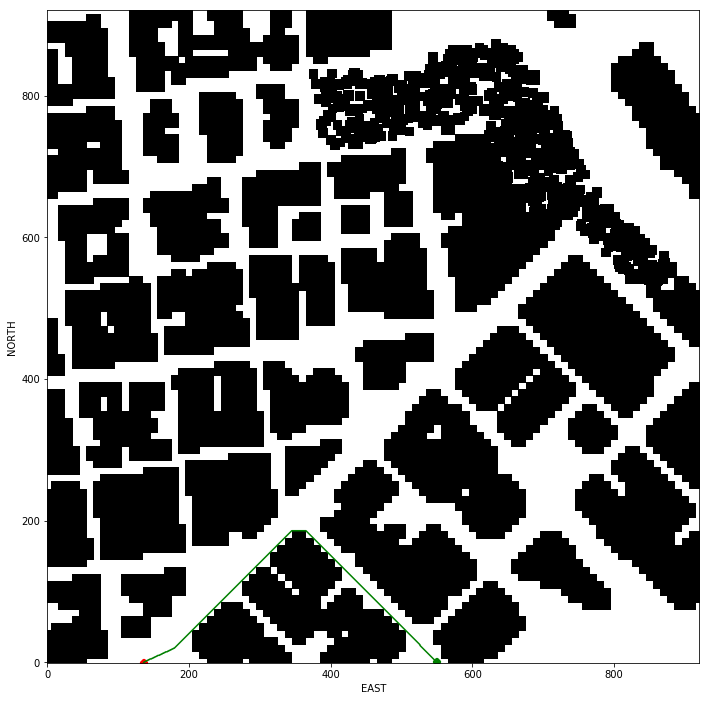

A* path:
(2, 548)
(3, 547)
(4, 546)
(5, 545)
(6, 544)
(7, 543)
(8, 542)
(9, 541)
(10, 540)
(11, 539)
(12, 538)
(13, 537)
(14, 536)
(15, 535)
(16, 534)
(17, 533)
(18, 532)
(19, 531)
(20, 530)
(21, 529)
(22, 528)
(23, 527)
(24, 526)
(25, 526)
(26, 525)
(27, 524)
(28, 523)
(29, 522)
(30, 521)
(31, 520)
(32, 519)
(33, 518)
(34, 517)
(35, 516)
(36, 515)
(37, 514)
(38, 513)
(39, 512)
(40, 511)
(41, 510)
(42, 509)
(43, 508)
(44, 507)
(45, 506)
(46, 505)
(47, 504)
(48, 503)
(49, 502)
(50, 501)
(51, 500)
(52, 499)
(53, 498)
(54, 497)
(55, 496)
(56, 495)
(57, 494)
(58, 493)
(59, 492)
(60, 491)
(61, 490)
(62, 489)
(63, 488)
(64, 487)
(65, 486)
(66, 485)
(67, 484)
(68, 483)
(69, 482)
(70, 481)
(71, 480)
(72, 479)
(73, 478)
(74, 477)
(75, 476)
(76, 475)
(77, 474)
(78, 473)
(79, 472)
(80, 471)
(81, 470)
(82, 469)
(83, 468)
(84, 467)
(85, 466)
(86, 465)
(87, 464)
(88, 463)
(89, 462)
(90, 461)
(91, 460)
(92, 459)
(93, 458)
(94, 457)
(95, 456)
(96, 455)
(97, 454)
(98, 453)
(99, 452)
(100, 451)
(101, 45

In [13]:
main()

In [14]:
data = np.loadtxt('colliders.csv', delimiter=',', dtype='Float64', skiprows=2)

In [15]:
data = np.loadtxt('colliders.csv', delimiter=',', dtype='Float64', skiprows=0)

ValueError: could not convert string to float: 'lat0 37.792480'

In [ ]:
#first_line = ""
with open('colliders.csv') as f:
    first_line = f.readline().strip()
print(first_line)    
latlon = first_line.split(',')
gs = float(latlon[0].strip().split(' ')[1])
ge = float(latlon[1].strip().split(' ')[1])
print(gs, ge)

In [ ]:
print(first_line.strip())